# Unseen Object Instance Segmentation

In [7]:
%matplotlib inline
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0" # TODO: Change this if you have more than 1 GPU

import sys
import json
from time import time
import glob

import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

# My libraries. Ugly hack to import from sister directory
import src.data_augmentation as data_augmentation
import src.segmentation as segmentation
import src.evaluation as evaluation
import src.util.utilities as util_
import src.util.flowlib as flowlib

## Depth Seeding Network Parameters

In [8]:
dsn_config = {

    # Sizes
    'feature_dim' : 64, # 32 would be normal

    # Mean Shift parameters (for 3D voting)
    'max_GMS_iters' : 10,
    'epsilon' : 0.05, # Connected Components parameter
    'sigma' : 0.02, # Gaussian bandwidth parameter
    'num_seeds' : 200, # Used for MeanShift, but not BlurringMeanShift
    'subsample_factor' : 5,

    # Misc
    'min_pixels_thresh' : 500,
    'tau' : 15.,

}

## Region Refinement Network parameters

In [9]:
rrn_config = {

    # Sizes
    'feature_dim' : 64, # 32 would be normal
    'img_H' : 224,
    'img_W' : 224,

    # architecture parameters
    'use_coordconv' : False,

}

# UOIS-Net-3D Parameters

In [10]:
uois3d_config = {

    # Padding for RGB Refinement Network
    'padding_percentage' : 0.25,

    # Open/Close Morphology for IMP (Initial Mask Processing) module
    'use_open_close_morphology' : True,
    'open_close_morphology_ksize' : 9,

    # Largest Connected Component for IMP module
    'use_largest_connected_component' : True,

}

In [11]:
checkpoint_dir = './checkpoints/models_3d/' # TODO: change this to directory of downloaded models
dsn_filename = checkpoint_dir + 'DepthSeedingNetwork_3D_TOD_checkpoint.pth'
rrn_filename = checkpoint_dir + 'RRN_OID_checkpoint.pth'
uois3d_config['final_close_morphology'] = 'TableTop_v5' in rrn_filename
uois_net_3d = segmentation.UOISNet3D(uois3d_config,
                                     dsn_filename,
                                     dsn_config,
                                     rrn_filename,
                                     rrn_config
                                    )

Let's use 1 GPUs for DSN!
Loaded DSNWrapper model
Let's use 1 GPUs for RRN!
Loaded RRNWrapper model


## Run on example OSD/OCID images

We provide a few [OSD](https://www.acin.tuwien.ac.at/en/vision-for-robotics/software-tools/osd/) and [OCID](https://www.acin.tuwien.ac.at/en/vision-for-robotics/software-tools/object-clutter-indoor-dataset/) images and run the network on them. Evaluation metrics are shown for each of the images.

In [19]:
example_images_dir = os.path.abspath('.') + '/example_images/bop_data/'

# OSD_image_files = sorted(glob.glob(example_images_dir + '/OSD_*.npy'))
# OCID_image_files = sorted(glob.glob(example_images_dir + '/OCID_*.npy'))
bop_image_files = sorted(glob.glob(example_images_dir + '/bop_*.npy'))
N = len(bop_image_files)


rgb_imgs = np.zeros((N, 480, 640, 3), dtype=np.float32)
xyz_imgs = np.zeros((N, 480, 640, 3), dtype=np.float32)
label_imgs = np.zeros((N, 480, 640), dtype=np.uint8)

for i, img_file in enumerate(bop_image_files):
    d = np.load(img_file, allow_pickle=True, encoding='bytes').item()

    # RGB
    rgb_img = d['rgb']
    rgb_img = rgb_img[:480, :640, ...]
    rgb_imgs[i] = data_augmentation.standardize_image(rgb_img)

    # XYZ
    xyz_imgs_ = d['xyz']
    xyz_imgs[i] = xyz_imgs_[:480, :640, ...]

    # Label
    label_imgs[i] = d['label'][:480, :640, ...]

batch = {
    'rgb' : data_augmentation.array_to_tensor(rgb_imgs),
    'xyz' : data_augmentation.array_to_tensor(xyz_imgs),
}

In [20]:
print("Number of images: {0}".format(N))

### Compute segmentation masks ###
st_time = time()
fg_masks, center_offsets, initial_masks, seg_masks = uois_net_3d.run_on_batch(batch)
total_time = time() - st_time
print('Total time taken for Segmentation: {0} seconds'.format(round(total_time, 3)))
print('FPS: {0}'.format(round(N / total_time,3)))

# Get results in numpy
seg_masks = seg_masks.cpu().numpy()
fg_masks = fg_masks.cpu().numpy()
center_offsets = center_offsets.cpu().numpy().transpose(0,2,3,1)
initial_masks = initial_masks.cpu().numpy()

Number of images: 4
Total time taken for Segmentation: 1.342 seconds
FPS: 2.981


/home/yumi/anaconda3/envs/uois3d/lib/python3.7/site-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/conda-bld/pytorch_1591914855613/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)
/home/yumi/anaconda3/envs/uois3d/lib/python3.7/site-packages/torch/nn/functional.py:3104: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
/home/yumi/anaconda3/envs/uois3d/lib/python3.

/home/yumi/Project/uois3d/src/evaluation.py:141: RuntimeWarning: invalid value encountered in double_scalars
  F[i,j] = (2 * prec * rec) / (prec + rec)
/home/yumi/Project/uois3d/src/evaluation.py:141: RuntimeWarning: invalid value encountered in double_scalars
  F[i,j] = (2 * prec * rec) / (prec + rec)


Image 1 Metrics:
{'Objects F-measure': 0.5135267291361055, 'Objects Precision': 0.9419387904524821, 'Objects Recall': 0.3529831396704759, 'Boundary F-measure': 0.363520184574139, 'Boundary Precision': 0.5536462699077954, 'Boundary Recall': 0.270595690747782, 'obj_detected': 11, 'obj_detected_075': 2, 'obj_gt': 24, 'obj_detected_075_percentage': 0.08333333333333333}
Image 2 Metrics:
{'Objects F-measure': 0.6262739561778414, 'Objects Precision': 0.8821574502860257, 'Objects Recall': 0.4854590154104455, 'Boundary F-measure': 0.44162733722327197, 'Boundary Precision': 0.6790123456790124, 'Boundary Recall': 0.3272274988692899, 'obj_detected': 9, 'obj_detected_075': 6, 'obj_gt': 21, 'obj_detected_075_percentage': 0.2857142857142857}
Image 3 Metrics:
{'Objects F-measure': 0.14591612633340306, 'Objects Precision': 0.9702712100139083, 'Objects Recall': 0.07889008255117042, 'Boundary F-measure': 0.0727021825180666, 'Boundary Precision': 0.36492890995260663, 'Boundary Recall': 0.04037267080745341

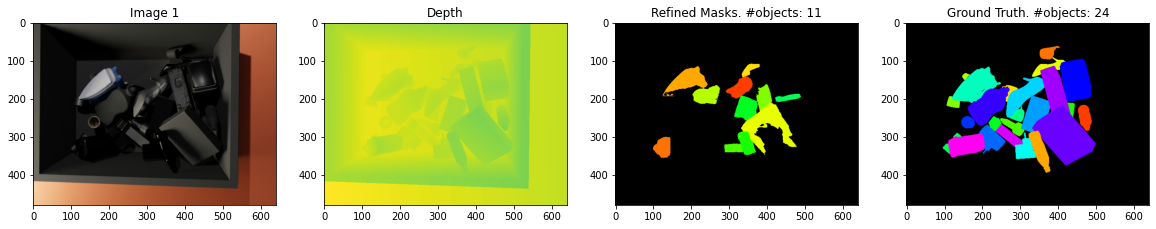

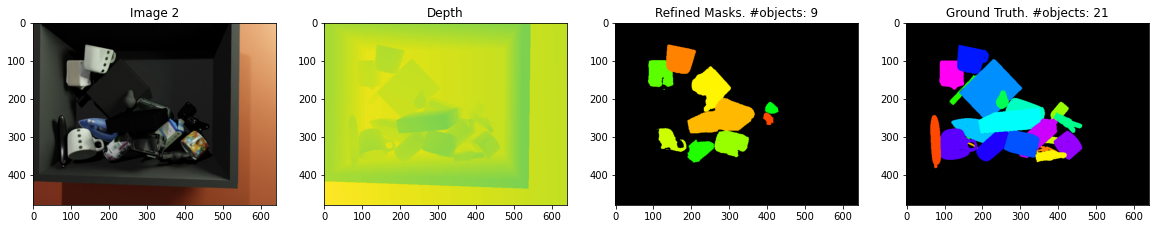

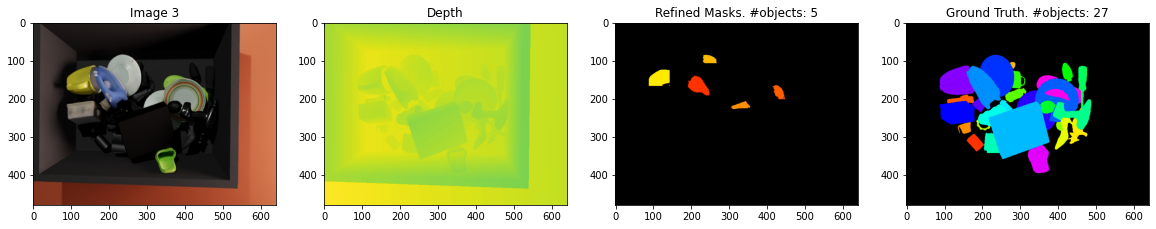

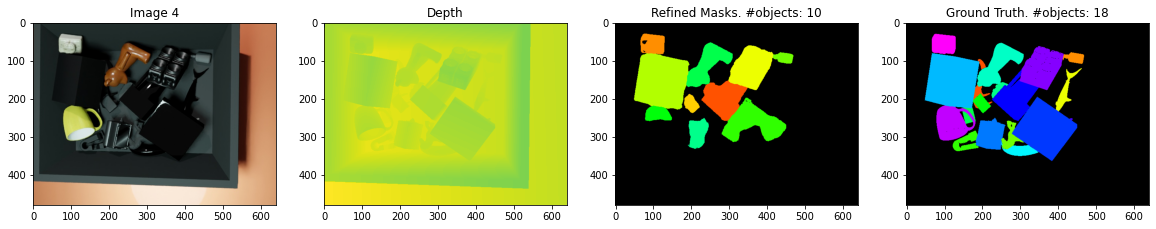

In [21]:
rgb_imgs = util_.torch_to_numpy(batch['rgb'].cpu(), is_standardized_image=True)
total_subplots = 6

fig_index = 1
for i in range(N):

    label_i = label_imgs[i, ...]
    label_i_unique = np.unique(label_i)
    num_objs = max(np.unique(seg_masks[i,...]).max(), np.unique(label_imgs[i,...]).max()) + 1

    rgb = rgb_imgs[i].astype(np.uint8)
    depth = xyz_imgs[i,...,2]
    seg_mask_plot = util_.get_color_mask(seg_masks[i,...], nc=num_objs)
    gt_masks = util_.get_color_mask(label_imgs[i,...], nc=num_objs)

    images = [rgb, depth, seg_mask_plot, gt_masks]
    titles = [f'Image {i+1}', 'Depth',
              f"Refined Masks. #objects: {np.unique(seg_masks[i,...]).shape[0]-1}",
              f"Ground Truth. #objects: {np.unique(label_imgs[i,...]).shape[0]-1}"
             ]
    util_.subplotter(images, titles, fig_num=i+1)

    # Run evaluation metric
    eval_metrics = evaluation.multilabel_metrics(seg_masks[i,...], label_imgs[i])
    print(f"Image {i+1} Metrics:")
    print(eval_metrics)
